In [4]:
# jalankan jika buka dengan google colab
!pip install scikit-learn-extra
!pip install -U yellowbrick
!pip install pyclustering

In [73]:
import pandas as pd
import numpy as np

# save model
import os
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib

from yellowbrick.cluster import KElbowVisualizer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.xmeans import xmeans as XMeans
import time

from sklearn import metrics

# Load Cleaned Data

In [2]:
data_path = 'https://raw.githubusercontent.com/zeerafle/text-mining-clustering/master/clean_tweets.tsv'
data = pd.read_csv(data_path, sep='\t')
data.head()

,Unnamed: 0,Unnamed: 0.1,id_str,from_user,text,created_at,time,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,user_location,status_url,entities_str
0,0,0,1417635429579247617,Kosasih0706,lama tolak vaksin abai dulu,Tue Jul 20 23:59:59 +0000 2021,21/07/2021 00:59:59,NaN,NaN,1.416723955424002e+18,H4CKN3T_,9.343577e+17,1.417449e+18,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1313265976...,68.0,159.0,NaN,http://twitter.com/Kosasih0706/statuses/141763...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
1,1,1,1417635417269051392,frhikma,bandara soeta sedia layan vaksin bagaimana pro...,Tue Jul 20 23:59:56 +0000 2021,21/07/2021 00:59:56,NaN,NaN,994248960.0,frhikma,9.942490e+08,1.417634e+18,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1415948130...,376.0,317.0,"Tangerang, Indonesia",http://twitter.com/frhikma/statuses/1417635417...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[]..."
2,2,2,1417635413716389889,dynayum,allah selamat hoax baru vaksin rubah dna buat ...,Tue Jul 20 23:59:55 +0000 2021,21/07/2021 00:59:55,NaN,NaN,NaN,NaN,5.579809e+07,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/1415156494...,503.0,313.0,NaN,http://twitter.com/dynayum/statuses/1417635413...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
3,3,3,1417635409480216580,estywukak,bantu ibu jawab iya ibu vaksin sinovac suntik ...,Tue Jul 20 23:59:54 +0000 2021,21/07/2021 00:59:54,NaN,NaN,NaN,NaN,2.994025e+08,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1399574428...,1639.0,3666.0,"Nusa Tenggara Timur, Indonesia",http://twitter.com/estywukak/statuses/14176354...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[]..."
4,4,4,1417635391927033856,zaqhisyam,bibi positif covid sempat vaksin tahan vaksin ...,Tue Jul 20 23:59:50 +0000 2021,21/07/2021 00:59:50,NaN,NaN,NaN,NaN,1.187276e+08,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/1392746882...,422.0,457.0,"Kelang, Selangor",http://twitter.com/zaqhisyam/statuses/14176353...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."


In [7]:
data.text[121]

'cara sederhana saturasi oksigen rendah pasien covid sedang isolasi diri perlu tahu'

In [8]:
pd.to_datetime(data.drop(index=3628).created_at)

0      2021-07-20 23:59:59+00:00
1      2021-07-20 23:59:56+00:00
2      2021-07-20 23:59:55+00:00
3      2021-07-20 23:59:54+00:00
4      2021-07-20 23:59:50+00:00
                  ...           
8780   2021-07-27 08:41:02+00:00
8781   2021-07-27 08:41:00+00:00
8782   2021-07-27 08:41:00+00:00
8783   2021-07-27 08:40:59+00:00
8784   2021-07-27 08:40:58+00:00
Name: created_at, Length: 8784, dtype: datetime64[ns, UTC]

In [9]:
len(data)

8785

In [10]:
data.duplicated('text').sum()

0

Ambil data yang kalimatnya lebih dari 2 kata

In [11]:
word_count = pd.Series(list(map(lambda x: len(str(x).split(" ")), data.text)))

word_count.describe()

count    8785.000000
mean       13.573591
std         8.377089
min         1.000000
25%         7.000000
50%        12.000000
75%        20.000000
max        55.000000
dtype: float64

In [12]:
data = data.loc[word_count > 2]
len(data)

8537

# Term Frequencies
TF (*Term Frequency*) adalah frekuensi dari kemunculan sebuah istilah dalam dokumen yang bersangkutan. Semakin besar jumlah kemunculan suatu term (TF tinggi) dalam dokumen, semakin besar pula bobotnya atau akan memberikan nilai keseuaian yang semakin besar. Berikut rumusnya:

$$
tf_{i,j} = \frac{n_{i,j}}{\sum_{k}n_{i,j}}
$$

Semerntara itu IDF merupakan sebuah perhitungan dari bagaimana term didistribusikan secara luas pada koleksi dokumen yang bersangkutan. IDF menunjukkan hubungan ketersediaan sebuah istilah dalam seluruh dekomuen. Semakin sedikit jumlah dokumen yang mengandung term yang dimaksud, maka nilai IDF semakin besar. IDF dihitung dengan:

$$
idf(w) = log(\frac{N}{df_{t}})
$$

Dengan mengombinasikan dua persamaan diatas kita dapat menemukan kata yang penting dalam dokumen (tweet). Rumus TF-IDF score adalah:

$$
w_{i,j} = tf_{i,j} * log(\frac{N}{df_{t}})
$$

---
**Referensi**
- [Text Mining dengan K-Means Clustering pada Tema LGBT dalam Arsip Tweet Masyarakat Kota Bandung](https://core.ac.uk/download/pdf/235583628.pdf)

In [13]:
# Untuk mengaplikasikan tf-idf, inputnya harus berupa list of tweet
tweets = data.text.to_list()
tweets[112:119]

['halo huan ying guan ling kenal julya chatime staff jababeka mau kasih tau kalau chatime banyak promo tau nya mulai promonya nampilin kartu vaksin nya dapet minum harga murah murah',
 'saran semua ppv lihat benar minta vaksinator hindar human error tipu moga jkjav lindung sehat atur sop percaya masyarakat program vaksinasi',
 'lebih satu juta lebih populasi terima dosis tunggal jumlah hampir satu juta lebih populasi dosis lengkap vaksinasi cara keluar pandemi cara konsisten praktik tindak sehat masyarakat',
 'cara sederhana saturasi oksigen rendah pasien covid sedang isolasi diri perlu tahu',
 'q list lho sdhan by link vaksin nusantara',
 'talok e dry hit the vaksin',
 'hari vaksin kemarin badan turun sakit tenggorok tahan benar badan cepat lelah minum vitamin obat flu makin hari suara mulai serak batuk alhamdulillah makin hari makin baik']

In [14]:
tfidf = TfidfVectorizer(max_features=None,
                       max_df=0.2,
                       min_df=5,
                       ngram_range=(1,2))
features = tfidf.fit_transform(tweets)

print(features.shape)

(8537, 4714)


## Term Document Matrix Untuk Pembobotan TF-IDF

In [ ]:
tdm_tfidf = pd.DataFrame(features.toarray(), index=['tweet ' + str(i+1) for i in range(len(data))])
tdm_tfidf.columns = tfidf.get_feature_names()
tdm_tfidf.head()

,aaa,abai,abang,abdi,acara,acara vaksinasi,ad,adakan,adha,adik,...,yo,yogyakarta,you,your,youtube,yuk,zaman,zeneca,zona,zoo
tweet 1,0.0,0.564896,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.227944,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 4,0.0,0.000000,0.189054,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 5,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tdm_tfidf.sum(axis=1).sort_values()

arief sulistyanto      0.789495
massal isolasi         0.789495
rangka kece            0.789495
dr had                 0.789495
komjen pol             0.789495
                        ...    
jadi                 116.407665
mau                  136.077679
hari                 158.196383
orang                159.989962
covid                161.763726
Length: 4714, dtype: float64

# Clustering

In [15]:
# untuk menampilkan top 10 words tiap cluster
def show_top_terms(cluster_centers, tfidf_matrix=features, terms=tfidf.get_feature_names()):
    print("Top terms per cluster:")
    order_centroids = cluster_centers.argsort()[:, ::-1]

    num_of_cluster = cluster_centers.shape[0]
    for i in range(num_of_cluster):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :num_of_cluster]:
            print(' %s' % terms[ind])
        print()

In [16]:
# saving model
def save_model(filename, model):
    os.makedirs(os.path.dirname("dumps/trained_models/result_oriented/"), exist_ok=True)

    with open('dumps/trained_models/result_oriented/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

# loading model
def load_model(filename):
    with open('dumps/trained_models/result_oriented' + filename, 'rb') as f:
        return pickle.load(f)

In [17]:
# labelling

# getting top 10 features
def get_top_features(cluster_centers, terms=tfidf.get_feature_names()):
    top_10_features = []
    current_cluster = []
    order_centroids = cluster_centers.argsort()[:, ::-1]
    
    num_of_cluster = cluster_centers.shape[0]
    for i in range(num_of_cluster):
        for ind in order_centroids[i, :10]:
            current_cluster.append(terms[ind])
        top_10_features.append(current_cluster)
        current_cluster = []
    
    return top_10_features

# create topic table
def create_topic_table(cluster_centers):
    num_of_cluster = cluster_centers.shape[0]
    table = pd.DataFrame({"terms": get_top_features(cluster_centers), "cluster": range(num_of_cluster)})
    table.terms = table.terms.apply(lambda x : ", ". join(x))
    
    return table

In [86]:
# create plot
def create_plot(model_labels, cluster_centers, title, tfidf_matrix=features):
    pca = PCA(n_components=2)
    scatter_plot_points = pca.fit_transform(tfidf_matrix.toarray())
    centroid_plot = pca.fit_transform(cluster_centers)
    
    unique_labels = set(model_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        class_member_mask = model_labels == k
        
        xy = scatter_plot_points[class_member_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.plot(
        centroid_plot[:, 0],
        centroid_plot[:, 1],
        "o",
        markerfacecolor="cyan",
        markeredgecolor="k",
        markersize=10,
    )

    plt.title(title)


In [19]:
# worcloud visualization
def create_wordcloud(result_table):
    import math
    
    num_of_cluster = len(result_table.cluster.unique())
    pict_row = math.ceil(num_of_cluster/2)
    
    fig, ax = plt.subplots(pict_row, 2, figsize=(10,15))
        
    for column in range(2):
        for row in range(pict_row):
            i = 0
            s = result_table[result_table.cluster == i]
            text = s['tweet'].str.cat(sep=' ')
            text = text.lower()
            text = ' '.join([word for word in text.split()])
            wordcloud = WordCloud(max_font_size=50, max_words=100,
                                 background_color='white').generate(text)
            
            try:
                ax[row, column].imshow(wordcloud, interpolation='bilinear')
                ax[row, column].axis('off')
                ax[row, column].set_title("Cluster" + str(row+column*pict_row))
            except IndexError:
                ax[column].imshow(wordcloud, interpolation='bilinear')
                ax[column].axis('off')
                ax[column].set_title("Cluster" + str(row+column*pict_row))
            i += 1

## K-Means Clustering

### Find Best Number of Cluster

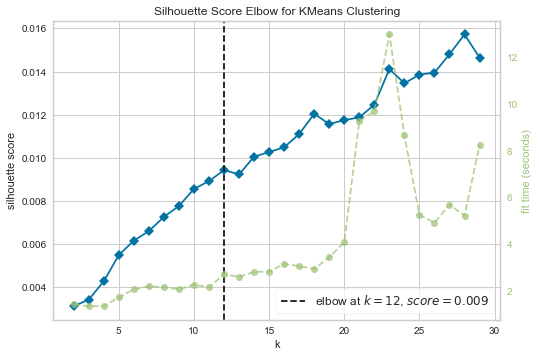

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMeans(algorithm='full', random_state=1), k=(2,30), metric='silhouette', timings=True)
visualizer.fit(features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Training

In [ ]:
kmeans = KMeans(12, random_state=1, algorithm='full')
kmeans.fit(features)

KMeans(algorithm='full', n_clusters=12, random_state=1)

In [ ]:
save_model('kmeans.model', kmeans)

In [ ]:
# jalankan jika sudah save model
kmeans = load_model('kmeans.model')

### Labelling

In [ ]:
create_topic_table(kmeans.cluster_centers_)

,terms,cluster
0,"aku, aku vaksin, vaksin aku, hari, aku vaksina...",0
1,"orang, banyak, orang orang, banyak orang, oran...",1
2,"hari, hari vaksin, vaksin hari, hari vaksinasi...",2
3,"covid, vaksin covid, vaksinasi covid, covid va...",3
4,"sertifikat, sertifikat vaksin, vaksin sertifik...",4
5,"apa, apa apa, vaksin apa, laku, apa laku, apa ...",5
6,"dosis, dosis vaksin, vaksin dosis, dosis perta...",6
7,"jadi, kalau, daftar, baru, jangan, lebih, bany...",7
8,"mau, mau vaksin, kalau, kalau mau, hari mau, h...",8
9,"benar, sinovac, vaksin sinovac, benar benar, c...",9


### Plotting Cluster

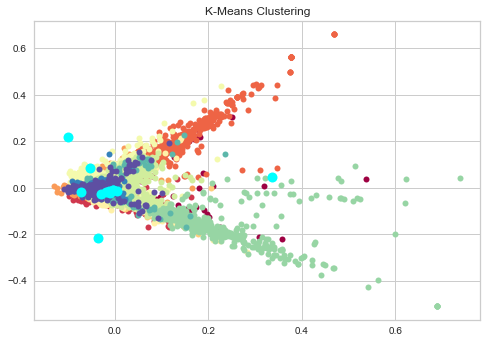

In [ ]:
create_plot(kmeans, kmeans.cluster_centers_, 'K-Means Clustering')

### Wordcloud per cluster

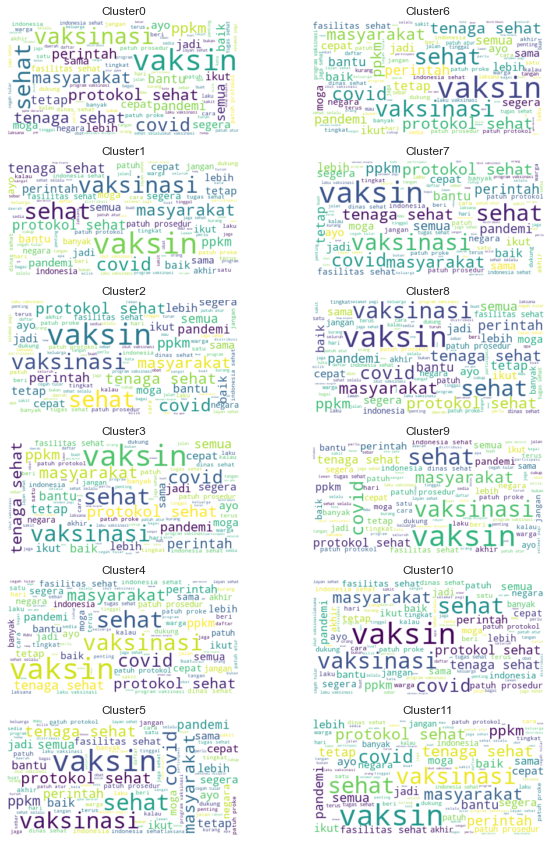

In [ ]:
result_kmeans = pd.DataFrame({"tweet": tweets, "cluster": kmeans.labels_})

create_wordcloud(result_kmeans)

In [ ]:
result_kmeans.cluster.value_counts()

7     4403
3      800
1      684
11     385
8      375
6      375
2      342
5      340
9      333
4      219
0      163
10     118
Name: cluster, dtype: int64

## K-Medoids Clustering

### Find Best Number of Cluster

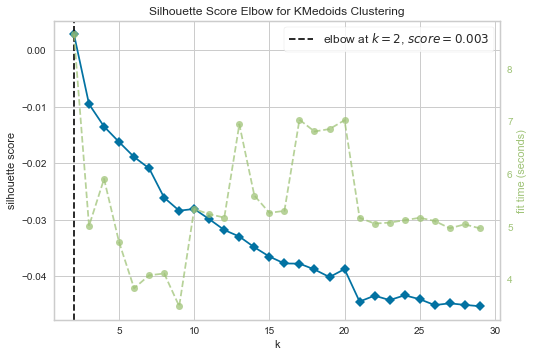

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMedoids(init='k-medoids++',
                                       random_state=1),
                              k=(2,30),
                              metric='silhouette',
                              timings=True)
visualizer.fit(features)        # Fit the data to the visualizer
visualizer.show()               # Finalize and render the figure

### Training

In [ ]:
kmedoids = KMedoids(2, random_state=1, init='k-medoids++', method='pam')
kmedoids.fit(features)

KMedoids(init='k-medoids++', method='pam', n_clusters=2, random_state=1)

In [ ]:
save_model('kmedoids.model', kmedoids)

In [ ]:
kmedoids = load_model('kmedoids.model')

### Labelling

In [ ]:
create_topic_table(kmedoids.cluster_centers_.toarray())

,terms,cluster
0,"zoo, jejak, jasa, jatah, jatah vaksin, jatim, ...",0
1,"hari vaksin, hari, jaya, jauh, jasa, jatah, ja...",1


### Plotting Cluster

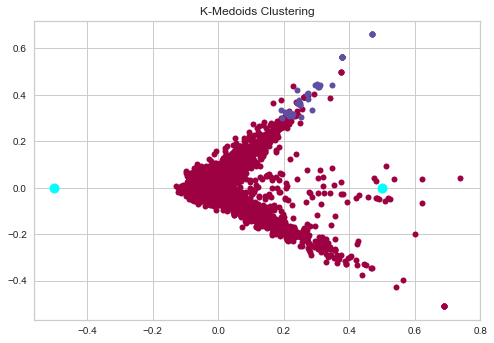

In [ ]:
create_plot(kmedoids, kmedoids.cluster_centers_.toarray(), 'K-Medoids Clustering')

### Wordcloud per cluster

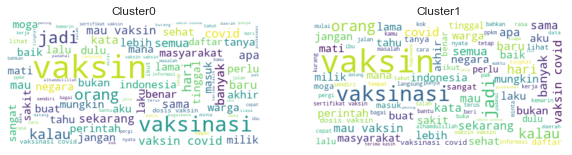

In [ ]:
result_kmedoids = pd.DataFrame({"tweet": tweets, "cluster": kmedoids.labels_})

create_wordcloud(result_kmedoids)

In [ ]:
result_kmedoids.cluster.value_counts()

0    8497
1      40
Name: cluster, dtype: int64

## Accelerated K-Means

### Find Best Number of Cluster

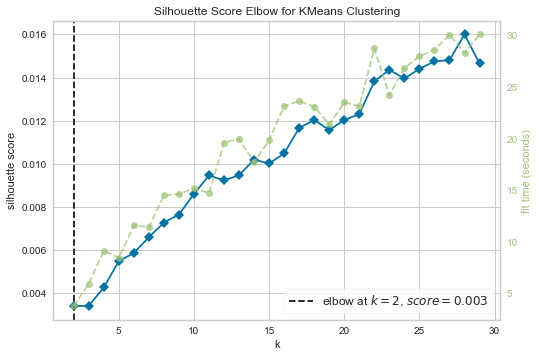

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMeans(algorithm='elkan',
                                     random_state=1),
                              k=(2,30),
                              metric='silhouette',
                              timings=True)
visualizer.fit(features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Training

In [ ]:
acc_kmeans = KMeans(2, random_state=1, algorithm='elkan')
acc_kmeans.fit(features)

KMeans(algorithm='elkan', n_clusters=2, random_state=1)

In [ ]:
save_model('acc_kmeans.model', acc_kmeans)

In [ ]:
# jalankan jika sudah save model
acc_kmeans = load_model('acc_kmeans.model')

### Labelling

In [ ]:
create_topic_table(acc_kmeans.cluster_centers_)

,terms,cluster
0,"hari, mau, mau vaksin, vaksin hari, hari vaksi...",0
1,"covid, orang, jadi, sehat, apa, dosis, banyak,...",1


### Plotting Cluster

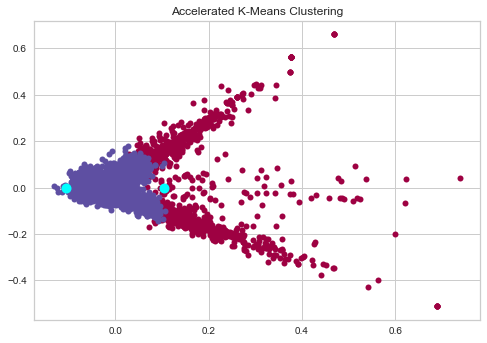

In [ ]:
create_plot(acc_kmeans, acc_kmeans.cluster_centers_, 'Accelerated K-Means Clustering')

### Wordcloud per cluster

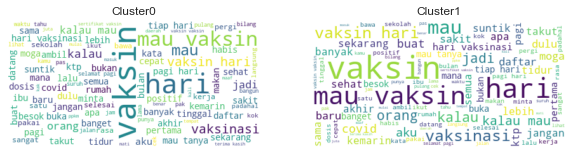

In [ ]:
result_acc_kmeans = pd.DataFrame({"tweet": tweets, "cluster": acc_kmeans.labels_})

create_wordcloud(result_acc_kmeans)

In [ ]:
result_acc_kmeans.cluster.value_counts()

1    7623
0     914
Name: cluster, dtype: int64

## X-Means

### Find Best Number of Cluster

In [33]:
silhouette_scores = []
exec_time = []
for i in range(2,30):
    t0 = time.time()
    
    initial_centers = kmeans_plusplus_initializer(features.todense(), i, random_state=1).initialize()
    xmeans_model = XMeans(features.todense(), initial_centers, i, random_state=1)
    xmeans_model.process()
    t1 = time.time() - t0
    
    exec_time.append(t1)
    
    xmeans_cluster = pd.Series(dtype='int64')
    for cluster_num, cluster in enumerate(xmeans_model.get_clusters()):
        for tweet_index in cluster:
            xmeans_cluster.at[tweet_index] = cluster_num
    
    xmeans_cluster.sort_index(inplace=True)
    
    silhouette_scores.append(metrics.silhouette_score(features, xmeans_cluster.to_numpy()))

In [20]:
with open('dumps/variables/silhouette_scores.pickle', 'rb') as f:
    silhouette_scores = pickle.load(f)
with open('dumps/variables/exec_time.pickle', 'rb') as f:
    exec_time = pickle.load(f)

In [47]:
elbow_point = silhouette_scores[0]
for i in range(len(silhouette_scores)):
    if elbow_point > silhouette_scores[i]:
        elbow_point = silhouette_scores[i-1]

In [68]:
elbow_point = np.array(elbow_point,)
vline_index = np.where(silhouette_scores == elbow_point)
vline = vline_index[0][0] + 2    # karena iterasi dimulai dari jumlah cluster 2
vline

2

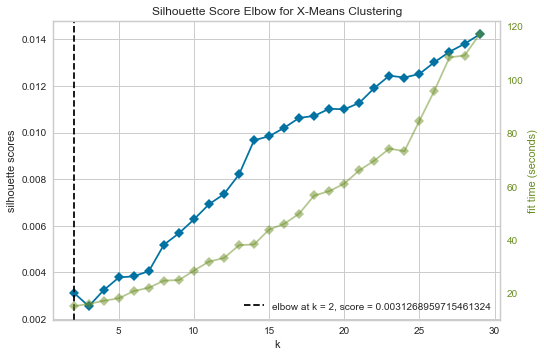

In [71]:
fig1 = matplotlib.figure.Figure()  # Make a figure
ax1 = fig1.add_subplot()           # Add the primary axis
ax1.plot(range(2,30), silhouette_scores, marker='D')        # Plot something
ax1.set_ylabel('silhouette scores')
ax1.set_xlabel('k')
ax1.set_title('Silhouette Score Elbow for X-Means Clustering')
dotted_line = ax1.axvline(vline, color='black', ls='--')
ax1.legend([dotted_line], [f'elbow at k = {vline}, score = {silhouette_scores[vline_index[0][0]]}'])

ax2 = ax1.twinx()                  # Add the secondary axis
ax2.plot(range(2,30), exec_time, color='olivedrab', marker='D', alpha=0.5)
ax2.grid(False)
ax2.set_ylabel('fit time (seconds)', color='olivedrab')
ax2.tick_params(axis='y', colors='olivedrab')
display(fig1)

### Training

In [74]:
initial_centers = kmeans_plusplus_initializer(features.todense(),
                                             2,
                                              random_state=1).initialize()
xmeans = XMeans(features.todense(), initial_centers, 2, random_state=1)
xmeans.process()

In [75]:
save_model('xmeans.model', xmeans)

In [ ]:
# jalankan jika sudah save model
xmeans = load_model('xmeans.model')

### Labelling

In [77]:
create_topic_table(np.array(xmeans.get_centers()))

,terms,cluster
0,"covid, orang, hari, jadi, sehat, apa, dosis, b...",0
1,"mau, mau vaksin, kalau, kalau mau, hari, vaksi...",1


### Plotting Cluster

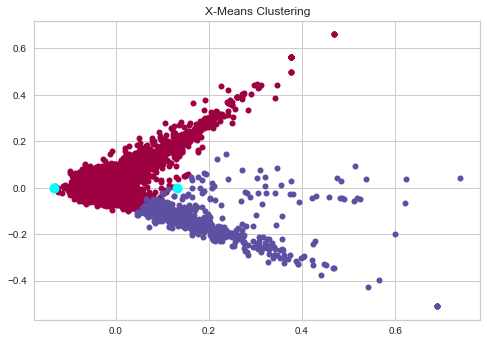

In [87]:
create_plot(result_xmeans.cluster.to_numpy(),
            np.array(xmeans.get_centers()),
            'X-Means Clustering')

### Wordcloud per cluster

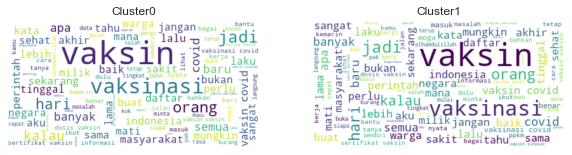

In [81]:
xmeans_cluster = pd.Series(dtype='int64')
for cluster_num, cluster in enumerate(xmeans.get_clusters()):
    for tweet_index in cluster:
        xmeans_cluster.at[tweet_index] = cluster_num
    
xmeans_cluster.sort_index(inplace=True)

result_xmeans = pd.concat(
    [pd.DataFrame({'tweet': tweets}),
     pd.DataFrame({'cluster': xmeans_cluster})],
    axis=1)

create_wordcloud(result_xmeans)

In [80]:
result_xmeans.cluster.value_counts()

0    7973
1     564
Name: cluster, dtype: int64